# ODE example

In [1]:
#numpy
import numpy as np
from numpy.random import multivariate_normal #For later example

#advectionGP
from advectionGP.models.mesh_1d_ode_model import AdjointSecondOrderODEModel as Model #Model module builds basic parts of the ODE problem, combines other classes into full model

'''To use other models in the class, such as the Advection Diffusion Reaction model, 
replace "AdjointSecondOrderODEModel" in the line above with "AdjointAdvectionDiffusionReaction" model
and adjust parameters as appropriate'''

from advectionGP.sensors import FixedSensorModel #Builds sensor arrays to generate data for foward model or to generate observations for comparison
from advectionGP.kernels import EQ #Generates exponentiated quadratic kernel approximation
#from advectionGP.test import TestKernels #Unit test model


#Plotting tools
import matplotlib.pyplot as plt

In [2]:
avg=0.01 # time that an observation is taken for
tlocL = np.linspace(0,9.9,10) # observation start times
X= np.zeros((len(tlocL),2)) # initiate X
# Build sensor locations
X[:,0] = tlocL #lower time#
X[:,1] = X[:,0]+avg # upper time

In [3]:
sensors = FixedSensorModel(X,0) # establish sensor model arguments are sensor locations and spatial averaging (not applicable in 1D case so set to 0)

In [4]:
k_0 = -1 #Diffusion coefficient
u=0.8
eta=5
noiseSD = 0.05 #Observation noise
N_feat=2000 # number of features used to approximate ground truth GP
boundary = ([0],[10])# edges of the grid - in units of time
kForward = EQ(0.6, 4.0) # generate EQ kernel arguments are lengthscale and variance
res = [500] # grid size for time

In [5]:
m = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=kForward,sensormodel=sensors,k_0=k_0,u=u,eta=eta) #initiate PDE model to build concentration

dt, Nt = m.getGridStepSize() # useful numbers!

z=np.random.normal(0,1.0,N_feat) # Generate z to compute source
sourceGT=m.computeSourceFromPhi(z)# Compute ground truth source by approximating GP
#sourceGT = np.ones(m.resolution)  # Example constant source
concTrain=m.computeResponse(sourceGT) # Compute concentration - runs ODE forward model
yTrain= m.computeObservations(addNoise='TRUE') # Compute observations with noise uses m.sensormodel for observation locations

In [6]:
#%%timeit
N_feat =200 #Number of features used to infer the source
kInverse = EQ(0.6, 4) # Initiate kernel for inverse problem
x = np.array([5,1,-10])#+np.random.normal(0,0.1,3)
x = np.array([0.8,5,-1])#+np.random.normal(0,0.1,3)
#x=[1,1,-1]
mInfer = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=kInverse,sensormodel=sensors,k_0=x[2],u=x[0],eta=x[1]) #Initiate new model for inference
mInfer.computeModelRegressors() # Compute regressor matrix 
meanZ, covZ = mInfer.computeZDistribution(yTrain) # Infers z vector mean and covariance using regressor matrix
sourceInfer = mInfer.computeSourceFromPhi(meanZ) # Generates estimated source using mean of the inferred distribution
concInfer=mInfer.computeResponse(sourceInfer) # Generates estimated concentration from inferred source



Computing SS...
Inverting SS...
Computing meanZ
Done


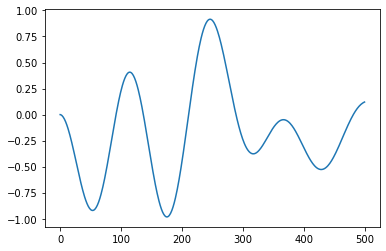

In [7]:
plt.plot(concInfer)

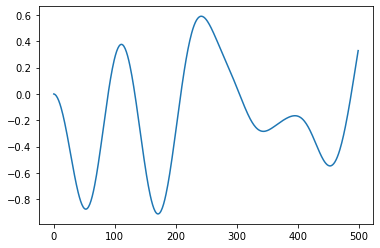

In [8]:
plt.plot(concTrain)

In [9]:
from advectionGP.gradient import SquaredErrorSamplingCost as cost

In [10]:
samples=cost.generateQSampleLocations(model=mInfer,nSamp=50)

In [11]:
cost.costResponseDerivativeSystem(x,model=mInfer,obs=yTrain,obsloc=(X[:,0:1]-X[:,1:])/2,sample=samples)

Computing SS...
Inverting SS...
Computing meanZ
Done


array([1.24500441e-05, 8.77429937e-06, 7.38457096e-05])

In [12]:
ca=cost.costFunctionSystem(np.array([5,1+1e-8,-10]),model=mInfer,obs=yTrain,obsloc=(X[:,0:1]-X[:,1:])/2,sample=samples)
cb=cost.costFunctionSystem(np.array([5,1-1e-8,-10]),model=mInfer,obs=yTrain,obsloc=(X[:,0:1]-X[:,1:])/2,sample=samples)
c=(ca-cb)/(2*1e-8)

Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done


In [13]:
c

-0.001460445328040072

In [14]:
reps=100

In [15]:
k_0v = np.linspace(-2,-1,reps)
uv = np.linspace(-0.2,0.8,reps)
etav = np.linspace(4,5,reps)

In [16]:
dL=np.zeros((3,reps))
dL[:,0]

array([0., 0., 0.])

In [17]:
dL=np.zeros((3,reps))
for i in range(reps):
    x=np.array([uv[i],etav[i],k_0v[i]])
    dL[:,i]=cost.costResponseDerivativeSystem(x,model=mInfer,obs=yTrain,obsloc=(X[:,0:1]-X[:,1:])/2,sample=samples)

Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing mean

In [18]:
dL.T

array([[-2.87917740e-01,  1.50920771e-01,  3.67909730e-01],
       [-3.04690648e-01,  1.42434539e-01,  3.55726986e-01],
       [-3.19205337e-01,  1.32382357e-01,  3.39379062e-01],
       [-3.31247866e-01,  1.21021240e-01,  3.19288939e-01],
       [-3.40642448e-01,  1.08613407e-01,  2.95921131e-01],
       [-3.47253154e-01,  9.54234561e-02,  2.69776209e-01],
       [-3.50985197e-01,  8.17155125e-02,  2.41384808e-01],
       [-3.51785748e-01,  6.77503787e-02,  2.11301199e-01],
       [-3.49644301e-01,  5.37827207e-02,  1.80096477e-01],
       [-3.44592540e-01,  4.00583200e-02,  1.48351440e-01],
       [-3.36703723e-01,  2.68114214e-02,  1.16649241e-01],
       [-3.26091566e-01,  1.42622083e-02,  8.55678886e-02],
       [-3.12908643e-01,  2.61443427e-03,  5.56726993e-02],
       [-2.97344294e-01, -7.94675872e-03,  2.75087787e-02],
       [-2.79622074e-01, -1.72568098e-02,  1.59364130e-03],
       [-2.59996752e-01, -2.51734694e-02, -2.15899386e-02],
       [-2.38750893e-01, -3.15782668e-02

In [19]:
x

array([ 0.8,  5. , -1. ])

In [20]:
diff=[[1e-8,0,0],[0,1e-8,0],[0,0,1e-8]]
diff[0]

[1e-08, 0, 0]

In [21]:
dLManual=np.zeros((3,reps))
diff=[[1e-8,0,0],[0,1e-8,0],[0,0,1e-8]]
for i in range(reps):
    x=np.array([uv[i],etav[i],k_0v[i]])
    for j in range(3):
        ca=cost.costFunctionSystem(np.array(x+diff[j]),model=mInfer,obs=yTrain,obsloc=(X[:,0:1]-X[:,1:])/2,sample=samples);
        cb=cost.costFunctionSystem(np.array(x-diff[j]),model=mInfer,obs=yTrain,obsloc=(X[:,0:1]-X[:,1:])/2,sample=samples);
        print(ca)
        print(cb)
        dLManual[j,i]=(ca-cb)/(2*1e-8)

Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.0376579762208228
0.03765798197926431
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.03765798060925091
0.037657977590836805
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.03765798277926613
0.037657975421017426
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.03980458624602761
0.03980459233997073
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.039804590717418716
0.039804587868727516
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.03980459285029444
0.039804585735740555
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.041554708747

Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.016930906541140763
0.016930907952854866
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.013940384993855838
0.013940388362903643
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.01394038626923812
0.0139403870875613
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.013940385889008143
0.013940387467779293
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.01112819448243428
0.011128197361747846
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.011128195516095693
0.011128196328086445
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.011128195093223877
0.011

Inverting SS...
Computing meanZ
Done
0.03260010388600323
0.03260010344647617
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.03260010500110548
0.03260010233137463
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.032600107685133495
0.03260009964738861
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.03840205687055403
0.03840205672277528
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.03840205823553027
0.03840205535779895
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.0384020611880472
0.0384020524053263
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.044505864844899753
0.04450586503987641
Computing SS...
Inverting SS...
Computing meanZ

Done
0.12394016600833367
0.12394015847148694
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.12457795962190346
0.12457796728542606
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.12457796425190676
0.12457796265538111
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.12457796676470066
0.12457796014261115
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.12450138807993948
0.12450139590581427
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.12450139264777425
0.12450139133798023
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.12450139482280614
0.12450138916293445
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting 

Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.04876154485912703
0.04876155099063483
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.043237420546481185
0.04323742351407617
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.04323742122208653
0.043237422838471096
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.043237418972274726
0.04323742508824824
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.037967798909461135
0.03796780147494113
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.03796779940636192
0.037967800978074444
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.037967797183443015
0.037967

Computing meanZ
Done
0.0006100423960039912
0.0006100424461273958
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.0006100424476997855
0.0006100423944299795
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.0006100425388427989
0.0006100423032874558
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.0007896912923527114
0.0007896913896453024
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.0007896913936428229
0.0007896912883551794
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.000789691568754747
0.0007896911132425673
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.0010692369859449753
0.001069237136053405
Computing SS...
Inverting SS...
Compu

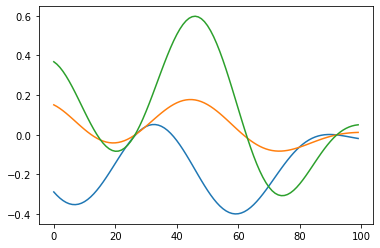

In [22]:
plt.plot(dL.T)

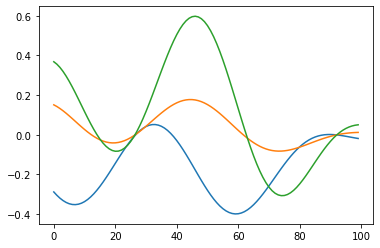

In [23]:
plt.plot(dLManual.T)

# PDE example

In [1]:
#numpy
import numpy as np
from numpy.random import multivariate_normal #For later example

#advectionGP

from advectionGP.models.mesh_adr1d_model import AdjointAdvectionDiffusionReaction1DModel as Model

from advectionGP.wind import WindSimple#Wind model


from advectionGP.sensors import FixedSensorModel #Builds sensor arrays to generate data for foward model or to generate observations for comparison
from advectionGP.kernels import EQ #Generates exponentiated quadratic kernel approximation
from advectionGP.kernels import GaussianBases #Generates exponentiated quadratic kernel approximation
#from advectionGP.test import TestKernels #Unit test model


#Plotting tools
import matplotlib.pyplot as plt

In [2]:
# generate sensor locations for training data with shape [total observations, 4], where each row has elements 
#[lower time location, upper time location, x location, y location]

tlocL = np.linspace(1,9,10) # lower time
xloc=np.linspace(1,9,10) # x locations
sensN = len(xloc) # total number of sensors 
obsN = len(tlocL) # total time points at which an observation is taken
X= np.zeros((obsN*sensN,3)) # obsN*sensN is total observations over all sensors and all times
# Build sensor locations
X[:,0] = np.asarray(np.meshgrid(tlocL,xloc)).reshape(2,sensN*obsN)[0] #lower time
X[:,2] = np.asarray(np.meshgrid(tlocL,xloc)).reshape(2,sensN*obsN)[1] # x location
X[:,1] = X[:,0]+0.1 # upper time

sensors = FixedSensorModel(X,0.001) # establish sensor model arguments are sensor locations and spatial averaging

In [3]:
k_0 = 0.01 #Diffusion
R=1
noiseSD = 0.05 #Observation noise
N_feat=2000 # number of features used to approximate ground truth GP
boundary = ([0,0],[10,10])# corners of the grid - in units of space
k = EQ(2, 2.0) # generate EQ kernel arguments are lengthscale and variance
res = [1000,100] # grid size for time, x and y


u1 = 0.01
u2 = 0.1
windmodel=WindSimple(u1,u2) # establish fixed wind model
m = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k,sensormodel=sensors,windmodel=windmodel,k_0=k_0,R=R) #initiate PDE model to build concentration

delta,Ns = m.getGridStepSize() # useful numbers!

z=np.random.normal(0,1.0,N_feat) # Generate z to compute source

sourceGT=(m.computeSourceFromPhi(z))# Compute source

#sourceGT = np.zeros(m.resolution)
#x = np.linspace(0,10,50)

#sourceGT[:,0:50]=np.exp(-(1/1)*(x-5)**2)

In [4]:
m.sensormodel=sensors
concTrain=m.computeResponse(sourceGT) # Compute concentration - runs advection diffusion forward model
yTrain= m.computeObservations(addNoise=True) # Compute observations with noise uses m.sensormodel for observation locations

In [5]:
N_feat =200 #Number of features used to infer the source
k1 = EQ(0.5, 1.0) 
k2 = EQ(2, 2.0) 

mInfer = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k2,sensormodel=sensors,windmodel=windmodel,k_0=k_0,R=R) #Initiate new model for inference
regressInfer = mInfer.computeModelRegressors() # Compute regressor matrix
meanZ, covZ = mInfer.computeZDistribution(yTrain) # Infers z vector mean and covariance
sourceInfer = mInfer.computeSourceFromPhi(meanZ) # Generates estimated source using inferred distributio
concInfer = mInfer.computeResponse(sourceInfer)

yOut = mInfer.computeObservations()



Computing SS...
Inverting SS...
Computing meanZ
Done


In [6]:
from advectionGP.gradient import SquaredErrorSamplingCost as cost

In [7]:
x = np.array([u1,k_0,R])

In [8]:
samples=cost.generateQSampleLocations(model=mInfer,nSamp=5)

In [9]:
cost.costResponseDerivativeSystem(x,model=mInfer,obs=yTrain,obsloc=np.array([(X[:,0]-X[:,1])/2,X[:,2]]).T,sample=samples)

Computing SS...
Inverting SS...
Computing meanZ
Done


array([-2.95979997e-05,  1.70690044e-05, -8.83527619e-05])

In [10]:
ca=cost.costFunctionSystem(np.array([u1,k_0+1e-8,R]),model=mInfer,obs=yTrain,obsloc=np.array([(X[:,0]-X[:,1])/2,X[:,2]]).T,sample=samples)
cb=cost.costFunctionSystem(np.array([u1,k_0-1e-8,R]),model=mInfer,obs=yTrain,obsloc=np.array([(X[:,0]-X[:,1])/2,X[:,2]]).T,sample=samples)
c=(ca-cb)/(2*1e-8)

Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done


In [11]:
x

array([0.01, 0.01, 1.  ])

In [28]:
reps=100

In [29]:
 diff=[[1e-8,0,0],[0,1e-8,0],[0,0,1e-8]]

In [30]:
k_0v = np.linspace(0.01,0.1,reps)
uv = np.linspace(0.01,0.1,reps)
Rv = np.linspace(0,5,reps)

In [31]:
dL=np.zeros((3,reps))
for i in range(reps):
    x=np.array([uv[i],k_0v[i],Rv[i]])
    dL[:,i]=cost.costResponseDerivativeSystem(x,model=mInfer,obs=yTrain,obsloc=np.array([(X[:,0]-X[:,1])/2,X[:,2]]).T,sample=samples)

Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing mean

In [32]:
dLManual=np.zeros((3,reps))
diff=[[1e-8,0,0],[0,1e-8,0],[0,0,1e-8]]
for i in range(reps):
    x=np.array([uv[i],k_0v[i],Rv[i]])
    for j in range(3):
        ca=cost.costFunctionSystem(np.array(x+diff[j]),model=mInfer,obs=yTrain,obsloc=np.array([(X[:,0]-X[:,1])/2,X[:,2]]).T,sample=samples);
        cb=cost.costFunctionSystem(np.array(x-diff[j]),model=mInfer,obs=yTrain,obsloc=np.array([(X[:,0]-X[:,1])/2,X[:,2]]).T,sample=samples);
        print(ca)
        print(cb)
        dLManual[j,i]=(ca-cb)/(2*1e-8)

Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.0008281574430397528
0.0008281574435309836
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.0008281573736923579
0.0008281575128783972
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.0008281574043499769
0.0008281574822207623
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.0006643672733787414
0.0006643672762086305
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.000664367244392113
0.0006643673051952672
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.0006643672486726744
0.000664367300914698
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
D

Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.00010583339572750266
0.0001058333963526513
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.00010583339627196566
0.00010583339580818826
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.00010583339497772783
0.00010583339710242615
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.000100715317182529
0.00010071531775877933
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.00010071531764021293
0.00010071531730109534
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.00010071531650753871
0.00010071531843376964
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
9.606269575974455e-05
9.606269629

Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
5.711898481456521e-05
5.711898491572171e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
5.7118984627542664e-05
5.7118985102744255e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
5.59503324498363e-05
5.595033261130985e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
5.595033248056157e-05
5.5950332580584584e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
5.595033230996102e-05
5.595033275118513e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
5.486451169993024e-05
5.486451185168783e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
5.486451

Computing meanZ
Done
4.476948684614869e-05
4.476948690830948e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
4.4769486808308716e-05
4.476948694614945e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
4.442671636512874e-05
4.4426716424450876e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
4.442671636469586e-05
4.4426716424883764e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
4.442671633011912e-05
4.44267164594605e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
4.4104896080747455e-05
4.410489613722008e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
4.410489607984271e-05
4.410489613812483e-05
Computing SS...
Inverting SS...


Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
4.092104096017406e-05
4.092104100605431e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
4.080573546145466e-05
4.080573548793881e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
4.0805735457315904e-05
4.080573549207757e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
4.080573545308392e-05
4.080573549630954e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
4.069703163293407e-05
4.069703165836781e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
4.069703162875245e-05
4.069703166254942e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
4.0697031

Done
3.960878363925847e-05
3.960878365447884e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
3.9569957339624634e-05
3.95699573531131e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
3.956995733547844e-05
3.9569957357259284e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
3.95699573392434e-05
3.956995735349433e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
3.953356048283095e-05
3.9533560495861504e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
3.95335604787107e-05
3.9533560499981764e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
3.95335604826806e-05
3.953356049601186e-05
Computing SS...
Inverting SS...
Computing meanZ
Don

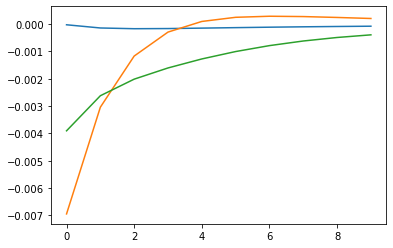

In [37]:
plt.plot(dL[:,0:10].T)


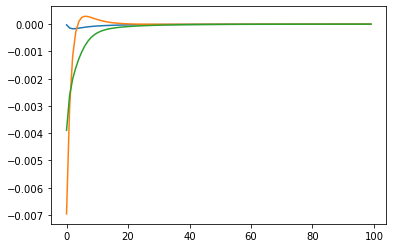

In [34]:
plt.plot(dLManual.T)

In [35]:
np.sum((dL-dLManual)**2)/100

4.551862682359567e-12

In [38]:
diff=[[1e-8,0,0],[0,1e-8,0],[0,0,1e-8]]
k_0v = np.linspace(0.01,0.5,reps)
uv = np.linspace(0.01,0.5,reps)
Rv = np.linspace(0,5,reps)

In [41]:
dLu=np.zeros((3,reps))
dLk_0=np.zeros((3,reps))
dLR=np.zeros((3,reps))
for i in range(reps):
    x=np.array([uv[i],k_0,R])
    dLu[:,i]=cost.costResponseDerivativeSystem(x,model=mInfer,obs=yTrain,obsloc=np.array([(X[:,0]-X[:,1])/2,X[:,2]]).T,sample=samples)
    x=np.array([0.5,k_0v[i],R])
    dLk_0[:,i]=cost.costResponseDerivativeSystem(x,model=mInfer,obs=yTrain,obsloc=np.array([(X[:,0]-X[:,1])/2,X[:,2]]).T,sample=samples)
    x=np.array([0.5,k_0,Rv[i]])
    dLR[:,i]=cost.costResponseDerivativeSystem(x,model=mInfer,obs=yTrain,obsloc=np.array([(X[:,0]-X[:,1])/2,X[:,2]]).T,sample=samples)     

Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing mean

Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting

In [51]:
dLManualu=np.zeros((3,reps))
dLManualk_0=np.zeros((3,reps))
dLManualR=np.zeros((3,reps))
diff=[[1e-8,0,0],[0,1e-8,0],[0,0,1e-8]]
for i in range(reps):
    for j in range(3):
        x=np.array([uv[i],k_0,R])

        ca=cost.costFunctionSystem(np.array(x+diff[j]),model=mInfer,obs=yTrain,obsloc=np.array([(X[:,0]-X[:,1])/2,X[:,2]]).T,sample=samples);
        cb=cost.costFunctionSystem(np.array(x-diff[j]),model=mInfer,obs=yTrain,obsloc=np.array([(X[:,0]-X[:,1])/2,X[:,2]]).T,sample=samples);
        print(ca)
        print(cb)
        dLManualu[j,i]=(ca-cb)/(2*1e-8)

        x=np.array([0.5,k_0v[i],R])


        ca=cost.costFunctionSystem(np.array(x+diff[j]),model=mInfer,obs=yTrain,obsloc=np.array([(X[:,0]-X[:,1])/2,X[:,2]]).T,sample=samples);
        cb=cost.costFunctionSystem(np.array(x-diff[j]),model=mInfer,obs=yTrain,obsloc=np.array([(X[:,0]-X[:,1])/2,X[:,2]]).T,sample=samples);
        print(ca)
        print(cb)
        dLManualk_0[j,i]=(ca-cb)/(2*1e-8)
        x=np.array([0.5,k_0,Rv[i]])
        ca=cost.costFunctionSystem(np.array(x+diff[j]),model=mInfer,obs=yTrain,obsloc=np.array([(X[:,0]-X[:,1])/2,X[:,2]]).T,sample=samples);
        cb=cost.costFunctionSystem(np.array(x-diff[j]),model=mInfer,obs=yTrain,obsloc=np.array([(X[:,0]-X[:,1])/2,X[:,2]]).T,sample=samples);
        print(ca)
        print(cb)
        dLManualR[j,i]=(ca-cb)/(2*1e-8)

Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
9.719287843757153e-05
9.719287902952555e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
9.288089252967985e-05
9.288089254552531e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.0020262358730595413
0.002026235820009656
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
9.719287890515695e-05
9.719287856194012e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
9.288089231068815e-05
9.288089276451701e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.0020262356729855405
0.002026236020083679
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
D

9.636947481587646e-05
9.636947533307848e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
9.225909343759276e-05
9.22590934874646e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.0004272182068695713
0.0004272181997080158
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
9.636947525163827e-05
9.636947489731662e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
9.225909327013513e-05
9.225909365492228e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.00042721819337650214
0.00042721821320108606
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
9.636947420339081e-05
9.636947594556413e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Co

Done
Computing SS...
Inverting SS...
Computing meanZ
Done
9.172861694229016e-05
9.172861702332192e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.00017215721880838952
0.00017215721749132555
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
9.565631012996832e-05
9.565630977896708e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
9.172861681642313e-05
9.172861714918892e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.0001721572167570098
0.00017215721954270537
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
9.565630909132443e-05
9.565631081761102e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
9.172861599634427e-05
9.172861796926784

Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.0001034565477068712
0.00010345654760289523
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
9.505023161617087e-05
9.505023128493e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
9.126201562667362e-05
9.126201592510305e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.00010345654733307634
0.0001034565479766901
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
9.505023059100242e-05
9.505023231009853e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
9.126201480408723e-05
9.126201674768945e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.000103456

Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
9.45455365013386e-05
9.454553620721204e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
9.083580500773953e-05
9.083580528508461e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
7.591762642252287e-05
7.591762665911188e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
9.454553549426025e-05
9.454553721429045e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
9.083580418716588e-05
9.083580610565826e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
7.591762592082113e-05
7.591762716081365e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
9.447073909

Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
9.043464220738105e-05
9.043464247128068e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
6.188998153645329e-05
6.188998166692153e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
9.41341226787925e-05
9.41341244070739e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
9.043464139116678e-05
9.043464328749499e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
6.188998125984004e-05
6.188998194353479e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
9.407394580390348e-05
9.407394604245444e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
9.0369556766

Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
5.3820058413666316e-05
5.3820058504842826e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
9.380606047049314e-05
9.380606221336967e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
9.005016784564941e-05
9.00501697219887e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
5.382005825406154e-05
5.38200586644476e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
9.375872624918806e-05
9.37587264364657e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
8.998737437625864e-05
8.998737454093244e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
5.282393147

4.884948456127008e-05
4.884948463201626e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
9.35504047257004e-05
9.355040648846925e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
8.967811973084199e-05
8.967812158889381e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
4.8849484466885526e-05
4.8849484726400815e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
9.351404919937108e-05
9.35140493429138e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
8.96171508264088e-05
8.961715100262222e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
4.821741804916565e-05
4.8217418149237596e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Com

Done
Computing SS...
Inverting SS...
Computing meanZ
Done
9.335599815441083e-05
9.335599994133102e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
8.931635301832476e-05
8.931635485948308e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
4.56508824476296e-05
4.565088261765821e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
9.33287867829687e-05
9.332878689016383e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
8.925697267172173e-05
8.925697285748152e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
4.523577374664001e-05
4.523577382335006e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
9.332878684468786e-05
9.332878682844466e-05


Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
8.896377086831198e-05
8.896377269375762e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
4.3529055435158894e-05
4.352905554939064e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
9.319227281672475e-05
9.319227289451669e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
8.890585483195602e-05
8.89058550256856e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
4.324969542067046e-05
4.324969547965704e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
9.319227282673595e-05
9.319227288450549e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
8.89058548

Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
4.209100318310678e-05
4.209100326120594e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
9.309462090635389e-05
9.309462096110032e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
8.856325486862738e-05
8.856325506906644e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
4.1899790292524245e-05
4.1899790338296964e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
9.309462086948313e-05
9.309462099797108e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
8.856325485487429e-05
8.856325508281956e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
4.189979

Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
9.302686055286127e-05
9.302686059028381e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
8.822883217286349e-05
8.822883237899326e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
4.096997960330767e-05
4.0969979639222804e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
9.302686047423466e-05
9.302686066891042e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
8.822883216466347e-05
8.82288323871933e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
4.096997960467095e-05
4.096997963785953e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
9.30268596

Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
8.790233043344149e-05
8.790233064442974e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
4.0325052533505436e-05
4.032505256200897e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
9.298097353910565e-05
9.298097379475945e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
8.790233043029894e-05
8.790233064757227e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
4.032505253349637e-05
4.0325052562018036e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
9.29809727101755e-05
9.298097462368961e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
8.7902329

Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
3.9877595111733985e-05
3.9877595134605216e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
9.29498905288357e-05
9.294989083989952e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
8.758352190821213e-05
8.758352212037942e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
3.9877595110814893e-05
3.9877595135524315e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
9.29498897112208e-05
9.294989165751445e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
8.758352112942422e-05
8.758352289916736e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
3.987759

Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
9.292746821918251e-05
9.292746857990819e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
8.72721826068631e-05
8.727218281407657e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
3.9569522636870346e-05
3.956952265843574e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
9.292746741010612e-05
9.292746938898463e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
8.727218183135355e-05
8.727218358958616e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
3.9569522639313155e-05
3.956952265599293e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
9.2924191

9.290845337001503e-05
9.290845377456347e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
8.696808278210266e-05
8.696808298451971e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
3.936132289098317e-05
3.9361322909933105e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
9.290845256684577e-05
9.290845457773274e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
8.696808200966002e-05
8.696808375696237e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
3.936132289490812e-05
3.9361322906008144e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
9.29052941967569e-05
9.290529420960794e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Co

Computing SS...
Inverting SS...
Computing meanZ
Done
8.66709848096137e-05
8.667098500739686e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
3.92255668979658e-05
3.9225566914722514e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
9.288843481107984e-05
9.288843685309852e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
8.667098404005522e-05
8.667098577695537e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
3.922556690282906e-05
3.922556690985926e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
9.288473663544017e-05
9.288473665067094e-05
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
8.662213212661206e-05
8.662213235162349e-05
Comp

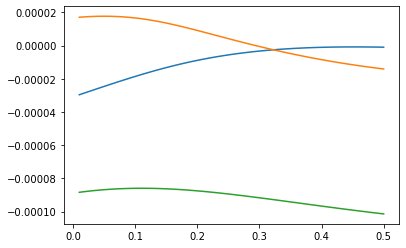

In [60]:
plt.plot(uv,dLu.T)

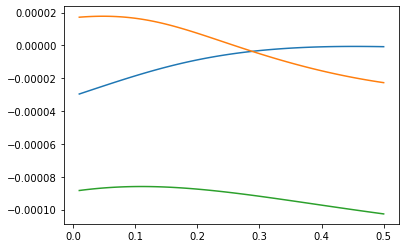

In [61]:
plt.plot(uv,dLManualu.T)